In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [7]:
signal = sio.loadmat('EMG_only_s41.mat')
all_left_2d = signal["x_left"]; all_right_2d =signal["x_right"]
all_left_2d.shape

(4, 358400)

In [10]:
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
import pandas as pd
import mne

df = pd.DataFrame(np.concatenate((all_left_2d,all_right_2d),axis = 1))
df.shape[0]*['emg']
sf = 512
ch_types = ["emg"]*df.shape[0]
chanels = ['brazo_1','brazo_2','brazo_3','brazo_4']
info = mne.create_info(ch_names = chanels ,sfreq=sf,ch_types=ch_types)
print(df.shape)
samples = df*1e-6 #pasar a voltios asumiendo que las unidades del dataset son microvoltios
loadedRaw = mne.io.RawArray(samples, info)
# loadedRaw.set_montage(montage = montage)
plt.figure(figsize=(21,150))  
loadedRaw.info


(4, 716800)
Creating RawArray with float64 data, n_channels=4, n_times=716800
    Range : 0 ... 716799 =      0.000 ...  1399.998 secs
Ready.


<Info | 7 non-empty values
 bads: []
 ch_names: brazo_1, brazo_2, brazo_3, brazo_4
 chs: 4 EMG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 512.0 Hz
>

<Figure size 1512x10800 with 0 Axes>

In [11]:
epochs = mne.make_fixed_length_epochs(loadedRaw, duration=1, preload=False)
epochs = epochs.get_data()
epochs.shape

Not setting metadata
1400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1400 events and 512 original time points ...
0 bad epochs dropped


(1400, 4, 512)

In [31]:
y_right= np.zeros(400); y_left = np.ones(400); y_neither = np.ones(600)*2# 0 = derecha //// 1 = izquierda

left_right = np.concatenate((left,right),axis = 0)
left_right.shape
all_data = np.concatenate((neither_left_right,left_right),axis = 0)
y_left_right = np.concatenate((y_left,y_right),axis = 0)
y_all_data = np.concatenate((y_neither,y_left_right),axis = 0)




In [48]:
def estandarizarCanal(channelArray):#shape (canales x tiempo)
    avg  = np.average(channelArray,axis = 1)
    # print(avg)
    std = np.std(channelArray,axis = 1)
    for i in range(4):  
        channelArray[i,:] = (channelArray[i,:]-avg[i])/std[i]
    # print(avg.shape, std.shape)
    # channelArray = (channelArray-avg)#/std
    #avg = avg.reshape(*avg.shape, 1)
    #avg.shape
    return channelArray

def estandarizarCanales(completeRun):
    for i in range(completeRun.shape[0]):
        completeRun[i,:,:] = estandarizarCanal(completeRun[i,:,:])
    return completeRun

all_data_std = estandarizarCanales(all_data)
all_data_std.shape


(1400, 4, 512)

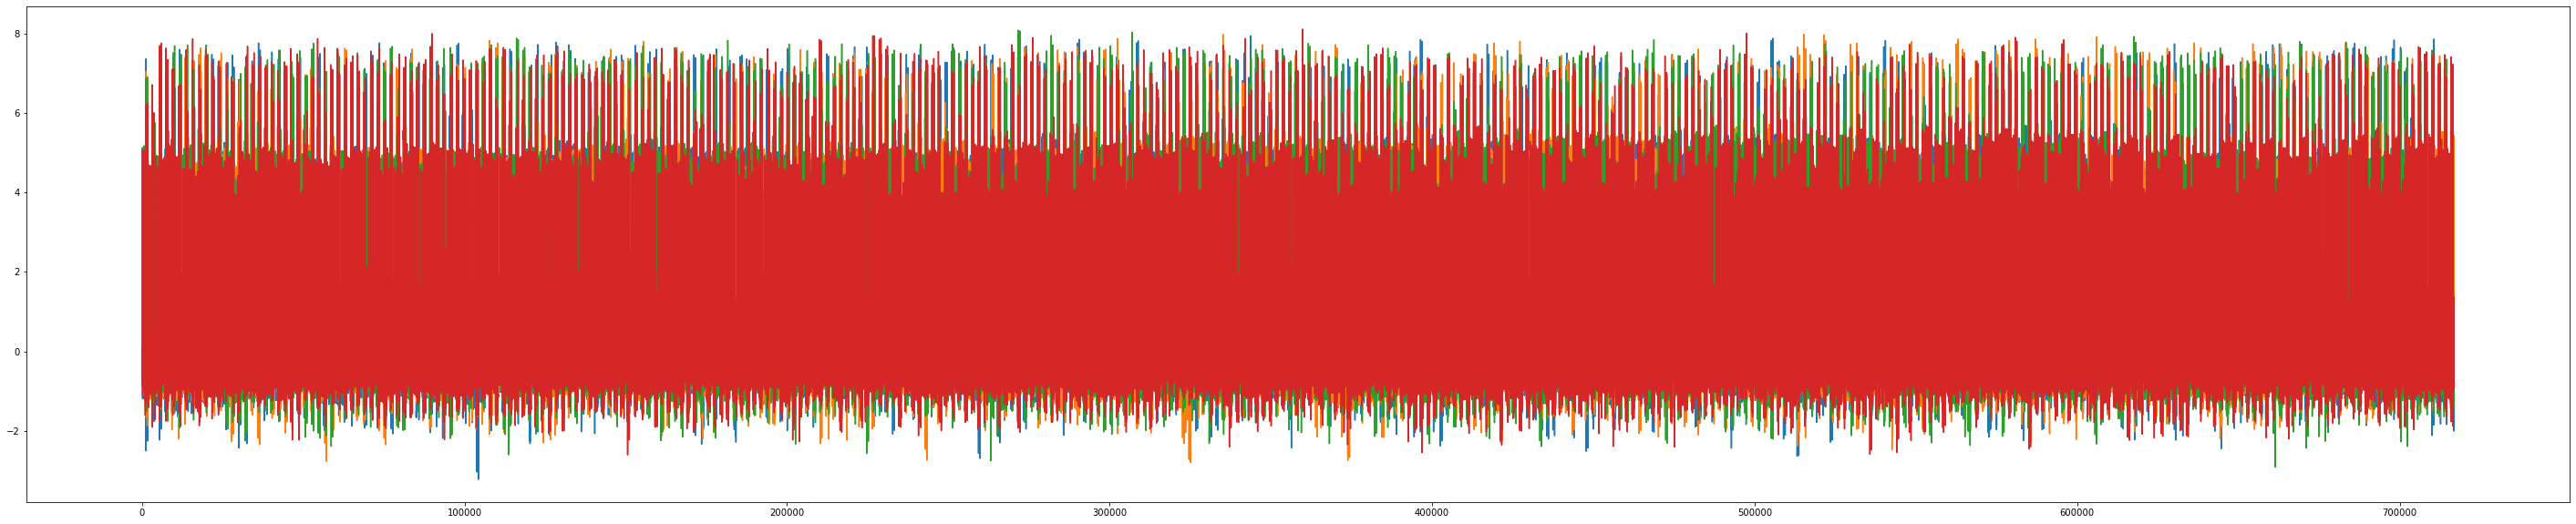

In [51]:
plt.figure(figsize = (50,10))
_ = plt.plot(all_data_std.reshape((4,-1)).T)

In [52]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

num_classes = 3

rand_i = np.random.choice(1400, 1400, replace=False)

x_train = all_data[rand_i[0:840]]
y_train = y_all_data[rand_i[0:840]]
y_test = y_all_data[rand_i[840:1400]]
x_test = all_data[rand_i[840:1400]]

y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
x_train.shape, y_train.shape, x_test.shape, y_test.shape,y_test[1:10]

((840, 4, 512),
 (840, 3),
 (560, 4, 512),
 (560, 3),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=float32))

In [179]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape[1:]),
        layers.Conv2D(32, kernel_size=(2,100), activation="relu"),
        layers.BatchNormalization(axis=1),
        layers.MaxPooling2D(pool_size=(2,2),padding = 'same'),
        layers.Conv2D(64, kernel_size=(1), activation="relu"),
        layers.MaxPooling2D(pool_size=(1)),
        layers.Flatten(),
        layers.Dropout(0.5),
     
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 3, 413, 32)        6432      
                                                                 
 batch_normalization_9 (Batc  (None, 3, 413, 32)       12        
 hNormalization)                                                 
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 2, 207, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 2, 207, 64)        2112      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 2, 207, 64)       0         
 g2D)                                                            
                                                     

In [177]:
input_shape = (4,4,512,1)
x = tf.random.normal((1,4,512,1))
y = tf.keras.layers.Conv2D(2,(1,40),activation='relu',input_shape=input_shape[1:])(x)
x = keras.layers.BatchNormalization(axis=1)
np.average(x,axis=1)




array([[[-1.84607804e-02],
        [ 3.85994911e-01],
        [-6.43982291e-01],
        [ 1.10476995e+00],
        [ 3.61658335e-02],
        [ 9.60476875e-01],
        [ 6.08213603e-01],
        [ 9.79063511e-02],
        [-3.72206151e-01],
        [-4.98466730e-01],
        [ 2.38726526e-01],
        [ 4.51596886e-01],
        [-4.13458124e-02],
        [ 3.62551302e-01],
        [-4.80091691e-01],
        [ 3.73752892e-01],
        [ 9.58079696e-02],
        [ 7.18270719e-01],
        [-7.00393856e-01],
        [ 1.34502724e-01],
        [ 1.07694209e-01],
        [-4.16817904e-01],
        [ 5.55386543e-02],
        [-3.69089723e-01],
        [ 4.44952659e-02],
        [-2.96505839e-01],
        [ 4.18364644e-01],
        [-2.52142549e-01],
        [-1.75023317e-01],
        [-4.51340944e-01],
        [ 9.58462134e-02],
        [ 6.84937060e-01],
        [-7.88085014e-02],
        [ 2.68282831e-01],
        [-7.18240142e-02],
        [ 5.53839326e-01],
        [ 7.91816711e-01],
 

In [ ]:

input_shape = (4,28,3)
x = tf.random.normal((1,28,3))
y = tf.keras.layers.Conv1D(2,3,activation='relu',input_shape=input_shape[1:])(x)
y.shape


In [181]:
batch_size = 5
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy",tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [183]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
152/152 [==============================] - 3s 20ms/step - loss: 0.5086 - accuracy: 0.7884 - recall_21: 0.7447 - precision_21: 0.8148 - val_loss: 1.6522 - val_accuracy: 0.4048 - val_recall_21: 0.3571 - val_precision_21: 0.4225
Epoch 2/10
152/152 [==============================] - 3s 20ms/step - loss: 0.3931 - accuracy: 0.8505 - recall_21: 0.8161 - precision_21: 0.8789 - val_loss: 1.8189 - val_accuracy: 0.3690 - val_recall_21: 0.3452 - val_precision_21: 0.3816
Epoch 3/10
152/152 [==============================] - 3s 20ms/step - loss: 0.3370 - accuracy: 0.8823 - recall_21: 0.8611 - precision_21: 0.8906 - val_loss: 1.8384 - val_accuracy: 0.4167 - val_recall_21: 0.3690 - val_precision_21: 0.4189
Epoch 4/10
152/152 [==============================] - 3s 20ms/step - loss: 0.3053 - accuracy: 0.8849 - recall_21: 0.8638 - precision_21: 0.8970 - val_loss: 1.9687 - val_accuracy: 0.3929 - val_recall_21: 0.3571 - val_precision_21: 0.4000
Epoch 5/10
152/152 [==============================] 

In [150]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
score

Test loss: 1.0746132135391235
Test accuracy: 0.4303571283817291


[1.0746132135391235, 0.4303571283817291, 0.0, 0.0]